# Hyperparameter Tuning

For demonstration purposes I runned the optimzation for 5 trials only to capture the output.
The whole optimization (~500 trials) is better to be made in multiprocessing with a `.py` file containing the objective function above. I followed this process behind the scenes.

## Results Processing and Analysis

In [ ]:
# Define parameters and metrics columns
hp_params = [
    'dropout', 'emb_weight', 'output_layer', 
    'initial_learning_rate', 'cross_layer', 'optimizer',
    'rating_layers', 'rating_units_l0', 'rating_units_l1'
]
hp_metrics = [
    'val_factorized_top_k/top_100_categorical_accuracy',
    'val_factorized_top_k/top_50_categorical_accuracy',
    'val_factorized_top_k/top_10_categorical_accuracy',
    'val_factorized_top_k/top_5_categorical_accuracy', 
    'val_factorized_top_k/top_1_categorical_accuracy',
    'val_root_mean_squared_error', 'val_loss'
]

# Helper function to parse study to pd.DataFrame and apply transformations
def process_study(study) -> pd.DataFrame:
    study_df = study.trials_dataframe()
    study_df.columns = study_df.columns.str.replace('user_attrs_', '')
    study_df.columns = study_df.columns.str.replace('params_', '')
    study_df = study_df[['number'] + hp_params + hp_metrics + ['state']]
    study_df['dropout'] = study_df['dropout'].round(1)
    study_df.fillna(0, inplace=True) # Replace non units in layers with 0
    units_cols = study_df.columns[study_df.columns.str.contains('unit')]
    study_df[units_cols] = study_df[units_cols].astype(int) # Convert units to int
    return study_df

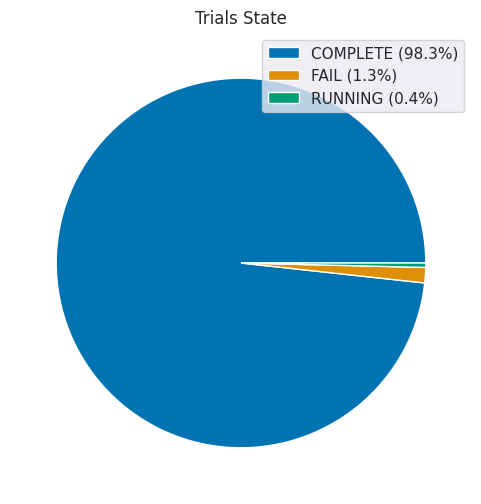

In [ ]:
# Convert study to dataframe and apply transformations
study_df = process_study(study)

fig = plt.figure(figsize=(6, 6))

# Calculate value counts and corresponding percentages
value_counts = study_df['state'].value_counts()
percentages = value_counts / value_counts.sum() * 100

# Create labels with both the state names and percentages
labels = [f'{state} ({percentage:.1f}%)' for state, percentage in zip(value_counts.index, percentages)]

# Plot the pie chart
value_counts.plot(kind='pie', labels=['' for i in range(len(labels))], ylabel='', title='Trials State')
plt.legend(labels=labels, loc='upper right')
plt.show()

Most failed and "running" trials occurred when the optimization process was abruptly halted or the kernel unexpectedly crashed.

In [ ]:
# Keep only completed trials
study_df = study_df[study_df['state'] == 'COMPLETE'].copy()

## Pareto Front

In [ ]:
# Create hover template
parameter_template = "".join([f"{p}: %{{text[{i + 1}]}}<br>" for i, p in enumerate(hp_params)])
metric_template = "".join([f"{m}: %{{text[{i + len(hp_params) + 1}]:.3f}}<br>" for i, m in enumerate(hp_metrics)])
hover_template = (
    "Trial number: %{text[0]}<br>" +
    "<br><b>Parameters</b><br>" +
    parameter_template +
    "<br><b>Metrics</b><br>" +
    metric_template +
    "<extra></extra>"
)

# Generate the color map for each parameter
colors = px.colors.qualitative.Set1

for param in hp_params:
    color_map = {cls: colors[i] for i, cls in enumerate(study_df[param].unique())}
    study_df[f"color_{param}"] = study_df[param].map(color_map)

# Create the initial figure
fig = go.Figure()

# Add default trace
fig.add_trace(go.Scatter(
    x=study_df['val_factorized_top_k/top_50_categorical_accuracy'],
    y=study_df['val_root_mean_squared_error'],
    mode='markers',
    marker=dict(size=8, color='gray'),
    name="None",
    text=study_df[['number'] + hp_params + hp_metrics],
    hovertemplate=hover_template
))

# Add traces for each parameter
for param in hp_params:
    for value in sorted(study_df[param].unique()):
        df = study_df[study_df[param] == value]
        fig.add_trace(go.Scatter(
            x=df['val_factorized_top_k/top_50_categorical_accuracy'],
            y=df['val_root_mean_squared_error'],
            mode='markers',
            marker=dict(size=8, color=df[f"color_{param}"]),
            name=f"{param}: {value}",
            text=df[['number'] + hp_params + hp_metrics],
            hovertemplate=hover_template
        ))

params_traces = [data.name for data in fig.data]

# Create a dropdown menu to change the color of the markers
updatemenus = [
    {
        'buttons':[
            {
                'label': param,
                'method': 'restyle',
                'args': [{'visible': [param in trace for trace in params_traces]}]
            }
            for param in ["None"] + hp_params
        ],
        'direction': 'down',
        'showactive': True,
        'x': 0.4,
        'xanchor': 'left',
        'y': 1.35,
        'yanchor': 'top',
        'name': 'Group'
    }
]

# Update layout with dropdown and axis titles
fig.update_layout(
    updatemenus=updatemenus,
    title="Pareto Front | Parameter: ",
    xaxis_title="Retrieval - Factorized Top 50 Categorical Accuracy",
    yaxis_title="Ranking - Root Mean Squared Error",
    yaxis=dict(rangemode='tozero', range=[0.31, 0.32]), 
    width=800,
    height=400
)

# Show the first figure as default
for k in range(1, len(fig.data)):
    fig.update_traces(visible=False, selector=k)
fig.show()


The most effective models are located in the bottom-right corner, where the RMSE error is minimized, and retrieval accuracy is maximiz## Key Insights:
1. **Initial Learning Rate**: Models with a learning rate of 0.1 consistently outperformed others, forming a distinct cluster of high-performing models.
2. **Cross Layer Effect**: Enabling cross layers generally led to poor performance, with only a few trials achieving satisfactory results.
3. **Optimizer Influence**: The choice of optimizer significantly impacted RMSE. Models trained with the Adam optimizer showed consistently highers than Adagrad.ments!

## Hyperparameter Importance

In [ ]:
# Parameters Importance by 'val_factorized_top_k/top_100_categorical_accuracy'
fig1= optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[0], target_name="val_factorized_top_k/top_50_categorical_accuracy"
)

# Parameters Importance by 'val_root_mean_squared_error'
fig2= optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[1], target_name="val_root_mean_squared_error"
)

# Create a subplot layout with 1 row and 2 columns
combined_fig = make_subplots(
    rows=2, cols=1, 
    subplot_titles=(
        "By <b>val_factorized_top_k/top_50_categorical_accuracy</b>",
        "By <b>val_root_mean_squared_error</b>"
    )
)

combined_fig.add_trace(fig1.data[0], row=1, col=1)
combined_fig.add_trace(fig2.data[0], row=2, col=1)

combined_fig.update_layout(
    title="Hyperparameter Importance",
    height=600,  
    width=800,  
    showlegend=False
)
combined_fig.show()



The top three parameters influenc`ng 'val_factorized_top_k/top_50_categorical_accu`acy' align with those identified in the Pareto front analysis. These parameters introduce the most significant variations in trial performance, as retrieval accuracy exhibits a broader range of variation compared to rankerror.ication!

## Parallel Coordinate Plot

In [ ]:
# Select only numerical parameters
num_cols = study_df[hp_params].select_dtypes(include='number').columns

# Build Parallel Coordinate Plot
layout = go.Layout(title="Parallel Coordinate Plot")
traces= [
    go.Parcoords(
        dimensions=
            [dict(label = col, values = study_df[col]) for col in num_cols] +
            [
                dict(tickvals = [0, 1], ticktext = ["Adagrad", "Adam"], label = "optimizer", values = study_df["optimizer"].replace({"Adagrad": 0, "Adam": 1})),
                dict(tickvals = [0, 1], ticktext = ["No", "Yes"], label = "cross_layer", values = study_df["cross_layer"].replace({False: 0, True: 1})),
                dict(range=(0, 1), label = "val_fact_top50", values = study_df["val_factorized_top_k/top_50_categorical_accuracy"]),
                dict(range=(0, 1), label = "val_rmse", values = study_df["val_root_mean_squared_error"])
            ],
        labelangle=30,
        labelside="bottom",
    )
]

fig = go.Figure(data=traces, layout=layout)
fig.show()

## Best Hyperparameters

Because the objective function is multi-objective, the best parameters are present in the best trials.

In [ ]:
best_trials = study_df[study_df['number'].isin([d.number for d in study.best_trials])]

fig = go.Figure()
# Add scatter plot trace
fig.add_trace(go.Scatter(
    x=best_trials['val_factorized_top_k/top_50_categorical_accuracy'],
    y=best_trials['val_root_mean_squared_error'],
    mode='markers',
    name='Best Trials',
    marker=dict(size=7, color='red'),
    text=best_trials[['number'] + hp_params + hp_metrics],
    hovertemplate=hover_template
))
# Update layout for better visualization
fig.update_layout(
    title="Pareto Front - Best Trials",
    xaxis_title="Retrieval - Factorized Top 50 Categorical Accuracy",
    yaxis_title="Ranking - Root Mean Squared Error",
    yaxis=dict(rangemode='tozero', range=[0.31, 0.32]) # Set rmse range to improve the visualization
)
fig.show()

Some of the best retrieval models are highly complex and resource-intensive, featuring elements such as cross-layer enablement, a large number of units in the rating deep layers, and very small learning rates. When retrained using cross-validation, these models exhibited high variance, suggesting instability and potential overfitting. In contrast, less complex models, such as Trial 471, demonstrated consistent performance across folds without any signs of overfitting.

Trial selected: **471**  
Best Hyperparameters:  
- cross_layer: False  
- dropout: 0.1  
- emb_weight: 8  
- initial_learning_rate: 0.1  
- optimizer: Adagrad  
- output_layer: 32  
- rating_layers: 2  
- rating_units_l0: 32  
- rating_units_l1: 64  

In [ ]:
PARAMETERS['LEARNING_RATE']['initial_learning_rate'] = 0.1
PARAMETERS['MODEL'] = {
    'emb_weight': 8,
    'user_layers': [32],
    'product_layers': [32],
    'rating_layers': [32, 64, 1],
    'dropout': 0.1,
    'optimizer': 'Adagrad',
    'cross_layer': False,
}

Despite the fact the model performs better without deep layers in query and candidates towers, also called deep retrieval model, as the dataset and the number of side features increase, incorporating deep layers will become essential for achieving better results.